# Curiosity-driven exploration with causality prior on the model in VectorIncrement environment

Setting the right GPU

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

Imports

In [18]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm.notebook import tqdm

tf.compat.v1.enable_v2_behavior()

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics, py_metrics
from tf_agents.policies import random_tf_policy, epsilon_greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.networks import actor_distribution_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import array_spec
from tf_agents.environments import utils, wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import py_driver

from vectorincrement import *
from common import *
from curiosity import *
from sparse_model_from_model import LinearStateTransitionModel, SparseModelLearner

from IPython.display import clear_output

import seaborn as sns

Environment hyperparameters

In [19]:
v_n = 5
v_k = 5
v_seed = 43
do_transform = True
time_limit = 20

Agent hyperparameters

In [35]:
num_iterations = 5000 # @param {type:"integer"}
collect_episodes_per_iteration = 20 # @param {type:"integer"}
replay_buffer_capacity = 1000 # @param {type:"integer"}

fc_layer_params = ()

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 100 # @param {type:"integer"}

# p norm
p_ord = 1

# regularization for reconstruction
eps_dinv = 1.

d_init_randomness = 5.

# for training observation model
model_W_train_epochs = 500

# for training feature model
model_sml_train_epochs = 1000

Decoder: a linear transformation from observations to features

In [36]:
# two layers, will sync parameters between them

W = LinearStateTransitionModel(o=v_k, a=v_n)
sml = SparseModelLearner(o=v_k, a=v_n, f=v_n, p_ord=p_ord,
                         eps_dinv=eps_dinv, d_init_randomness=d_init_randomness)

decoder_layer_agent = tf.keras.layers.Dense(v_n, input_shape=(v_k,), activation=None,
                             use_bias=False, kernel_initializer='random_normal')

Model of the environment

In [37]:
def env_model(oa):
    """Models next observation given o and a."""
    oa = oa[0]
    o = oa[:v_k]
    a = oa[v_k:]
    D = sml.D.numpy()
    Mf, Ma = sml.get_MfMa(sml.D)
    Mf = Mf.numpy()
    Ma = Ma.numpy()
    result = np.linalg.inv(D) @ (Ma @ a + Mf @ D @  o)
    return np.array([result])

Curiosity parameters

In [38]:
alpha = 1.0

curiosity_interval = 10

Creating a curiosity-wrapped environment

In [39]:
def get_env(add_curiosity_reward=True):
    """Return a copy of the environment."""
    env = VectorIncrementEnvironmentTFAgents(v_n=v_n, v_k=v_k, v_seed=v_seed,
                                             do_transform=do_transform)
    env = wrappers.TimeLimit(env, time_limit)
    if add_curiosity_reward:
        env = CuriosityWrapper(env, env_model, alpha=alpha)
    env = tf_py_environment.TFPyEnvironment(env)
    return env

In [40]:
train_env = get_env(add_curiosity_reward=True)
eval_env = get_env(add_curiosity_reward=False)

In [41]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    activation_fn=tf.keras.activations.relu,
    preprocessing_layers=decoder_layer_agent
    # for features: add preprocessing_layers=[...]
)

In [42]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [43]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [44]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [45]:
curiosity_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=1000000) # should never overflow

In [46]:
decoder_layer_agent = actor_net.layers[0].layers[0] # taking the copied layer with actual weights

# sml initializes D properly
decoder_layer_agent.set_weights([sml.D.numpy().T])

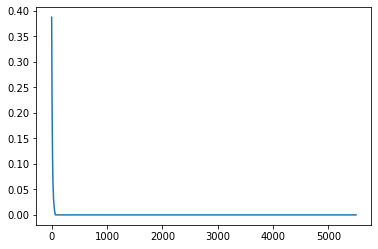

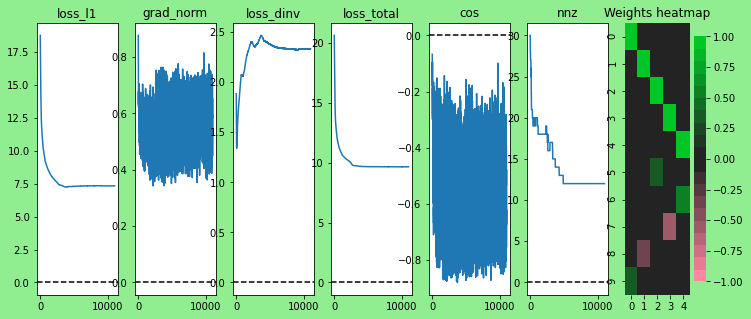

  2%|▏         | 110/5000 [20:08<14:55:36, 10.99s/it]


KeyboardInterrupt: 

In [47]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
train_avg_return = compute_avg_return(eval_env, tf_agent.collect_policy, num_eval_episodes)
returns = [avg_return]
train_returns = [train_avg_return]

for _ in tqdm(range(num_iterations)):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(train_env, tf_agent.collect_policy,
                  collect_episodes_per_iteration,
                  [replay_buffer,curiosity_replay_buffer])

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()
    
  #print("Agent train step")

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    train_avg_return = compute_avg_return(train_env, tf_agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1} Train curiosity Average return = {2}'.format(step, avg_return,
                                                                      train_avg_return))
    returns.append(avg_return)
    train_returns.append(train_avg_return)
    
  if step % curiosity_interval == 0 and len:
    clear_output()
    xs, ys = buffer_to_dataset(curiosity_replay_buffer, v_n)
    
    # fitting on observational data...
    W.fit(xs=xs, ys=ys, epochs=model_W_train_epochs)
    #W.plot_loss()
    
    # setting weights from the agent to the model...
    sml.D.assign(decoder_layer_agent.get_weights()[0].T)
    
    # setting the new observation transition matrix
    sml.set_WoWa(*W.get_Wo_Wa())
    
    # fitting the SML model
    sml.fit(epochs=model_sml_train_epochs)
    
    # setting weights from the model to the agent...
    decoder_layer_agent.set_weights([sml.D.numpy().T])
    
    # plotting results for W and sml
    W.plot_loss()
    sml.process_results()
    
    #curiosity_replay_buffer.clear()
    
    #print("Model train step")

In [52]:
returns

[1.0, 9.666665]

ValueError: x and y must have same first dimension, but have shapes (51,) and (2,)

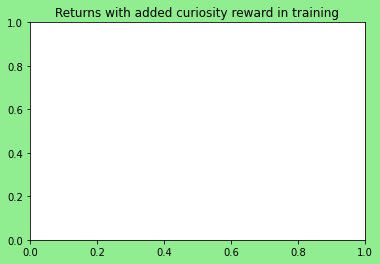

In [48]:
steps = range(0, num_iterations + 1, eval_interval)
fig = plt.figure()
fig.patch.set_facecolor('lightgreen')
plt.title("Returns with added curiosity reward in training")
plt.plot(steps, returns, label="eval")
plt.plot(steps, train_returns, label="train")
plt.ylabel('Average Return')
plt.axhline(time_limit / 2, color='red', label='max reward')
plt.legend()
plt.xlabel('Step')

# Training on random policy

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(
    train_env.time_step_spec(),
    train_env.action_spec())

In [ ]:
curiosity_replay_buffer.clear()
collect_episode(eval_env, random_policy, 500, [curiosity_replay_buffer])
xs, ys = buffer_to_dataset(curiosity_replay_buffer, v_n)

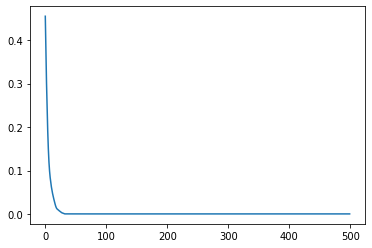

In [27]:
p_ord = 1

W = LinearStateTransitionModel(o=v_k, a=v_n)


# fitting on observational data...
W.fit(xs=xs, ys=ys, epochs=500)
W.plot_loss()

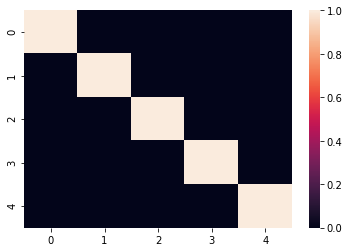

In [28]:
sns.heatmap(W.get_Wo_Wa()[0])

In [29]:
p_ord = 1

sml = SparseModelLearner(o=v_k, a=v_n, f=v_n,
                         p_ord=p_ord, eps_dinv=1,
                         d_init_randomness=5)

# setting the new observation transition matrix
sml.set_WoWa(*W.get_Wo_Wa())

# fitting the SML model
sml.fit(epochs=5000)

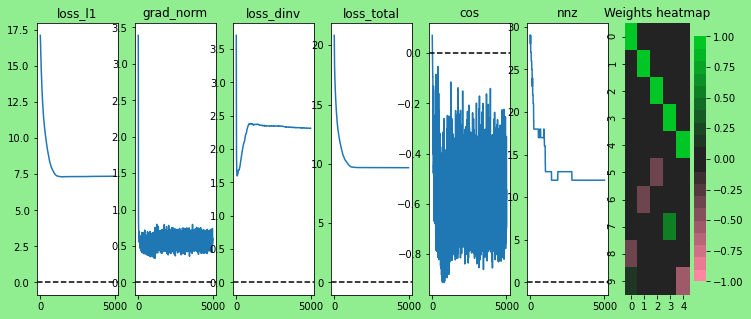

In [30]:
sml.process_results()

In [22]:
E = train_env._env.envs[0]._env._env.env.e.model.weights[0].numpy().T

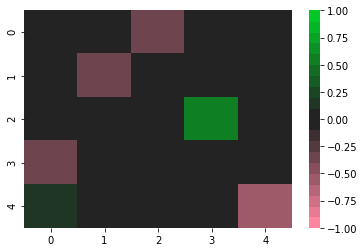

In [31]:
cm = sns.diverging_palette(0, 129, l=70, s=100, n=20, center="dark")

sns.heatmap(sml.D.numpy() @ E, vmin=-1, vmax=1, cmap=cm)

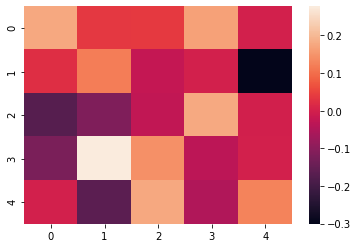

In [24]:
sns.heatmap(np.linalg.pinv(sml.D.numpy()))

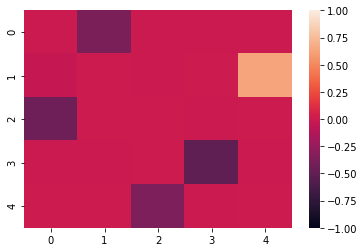

In [112]:
sns.heatmap(sml.Ma, vmin=-1, vmax=1)

In [113]:
xs.shape

(10000, 10)

In [114]:
train_env

In [115]:
train_env._env.envs[0]._env._env.env.e.model.layers[0].activation

<function tensorflow.python.keras.activations.linear(x)>

(array([1991.,    0., 1936.,    0.,    0., 2060.,    0., 1975.,    0.,
        2038.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

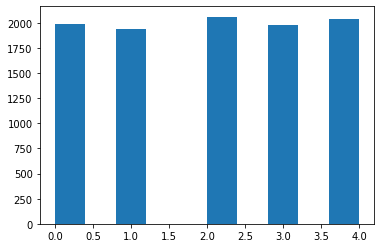

In [116]:
plt.hist(np.argmax(xs[:,v_n:], axis=1))

In [56]:
from graphviz import Digraph

In [57]:
def graph_for_matrices(Mf, Ma, threshold=1e-2):
    """Visualize matrices as a graph."""
    # dimension
    v_n = sml.Ma.shape[0]

    ps = Digraph(name='Causal model', engine='neato')#,
                 #node_attr={'shape': 'plaintext'})

    # adding features nodes
    for f in range(v_n):
        ps.node('f%02d' % f, color='green')
        ps.node("f'%02d" % f, color='blue')

    # adding action edges
    for a in range(v_n):
        ps.node('a%02d' % a, color='red')

    # adding edges
    edges = 0

    for f1, a in zip(*np.where(np.abs(sml.Ma) > threshold)):
        ps.edge('a%02d' % a, "f'%02d" % f1)
        edges += 1

    for f1, f in zip(*np.where(np.abs(sml.Mf) > threshold)):
        ps.edge('f%02d' % f, "f'%02d" % f1)
        edges += 1
    
    max_edges = v_n ** 2 * 2
    print("Number of edges: %d out of %d, sparsity %.2f%%" % \
          (edges, max_edges, 100 - 100. * edges / max_edges))
        
    return ps

Number of edges: 12 out of 50, sparsity 76.00%


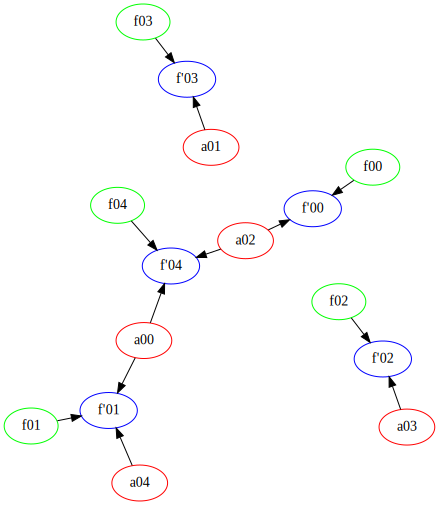

In [58]:
graph_for_matrices(sml.Mf, sml.Ma)